In [1]:
# first some imports
import cdsapi #Interface into ERA5 data
import pyart # The Python ARM Radar Toolkit
import cartopy.crs as ccrs # A toolkit for map projections
import cartopy.feature as cfeature # A method for adding coastlines etc
import cartopy.io.img_tiles as cimgt # an API into things like google maps
import numpy as np #The famous numpy package!
from matplotlib import pyplot as plt
import os
import xarray as xr
import pydda
#Now a Jupyter "Magic" for plotting inline
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Iterator
/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/publish.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/scheduler.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, deque, OrderedDict, Mapping, Set
/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/scheduler.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead o

In [2]:
#Load the radar, this time using the ODIM reader
radar = pyart.aux_io.read_odim_h5(os.path.expanduser('~/data/aus/terryhills/71_20181220_060028.pvol.h5'))

In [3]:
#lets see what is in here!
#How many sweeps?
print(radar.nsweeps)

14


In [4]:
#What tilts?
print(radar.fixed_angle['data'])

[ 0.5  0.9  1.3  1.8  2.4  3.1  4.2  5.6  7.4 10.  13.3 17.9 23.9 32. ]


In [5]:
#what fields
print(radar.fields.keys())

dict_keys(['reflectivity', 'velocity', 'total_power', 'differential_reflectivity', 'cross_correlation_ratio', 'differential_phase', 'specific_differential_phase'])


In [6]:
#range?
print(radar.range['data'][-1]/1000.0)

299.75


# Lets plot a PPI

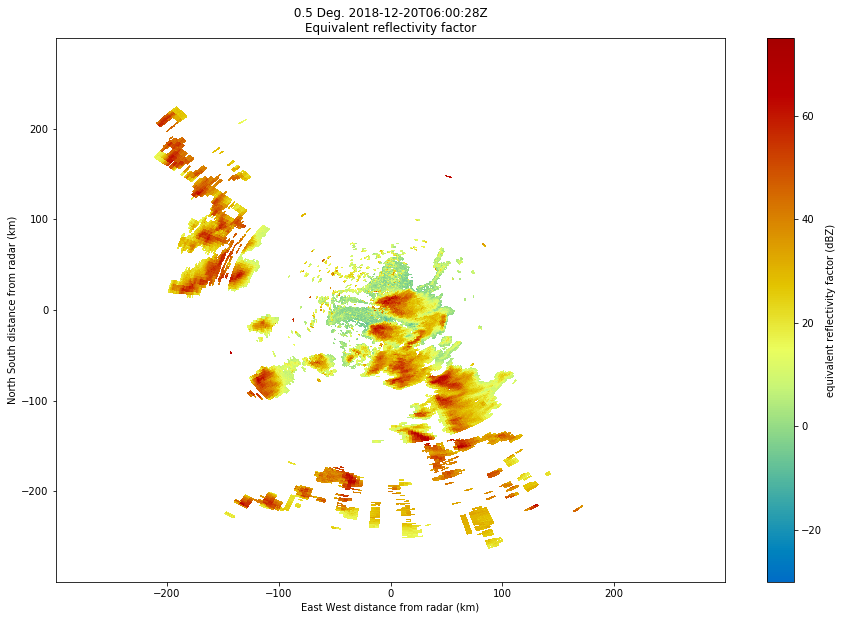

In [7]:
my_figure = plt.figure(figsize=[15,10])
my_radar_display = pyart.graph.RadarDisplay(radar)
my_radar_display.plot_ppi('reflectivity', 0)

min_lat: -36.394470337131885  min_lon: 147.97069738233253  max_lat: -31.007133361598594  max_lon: 154.44730190304745


/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


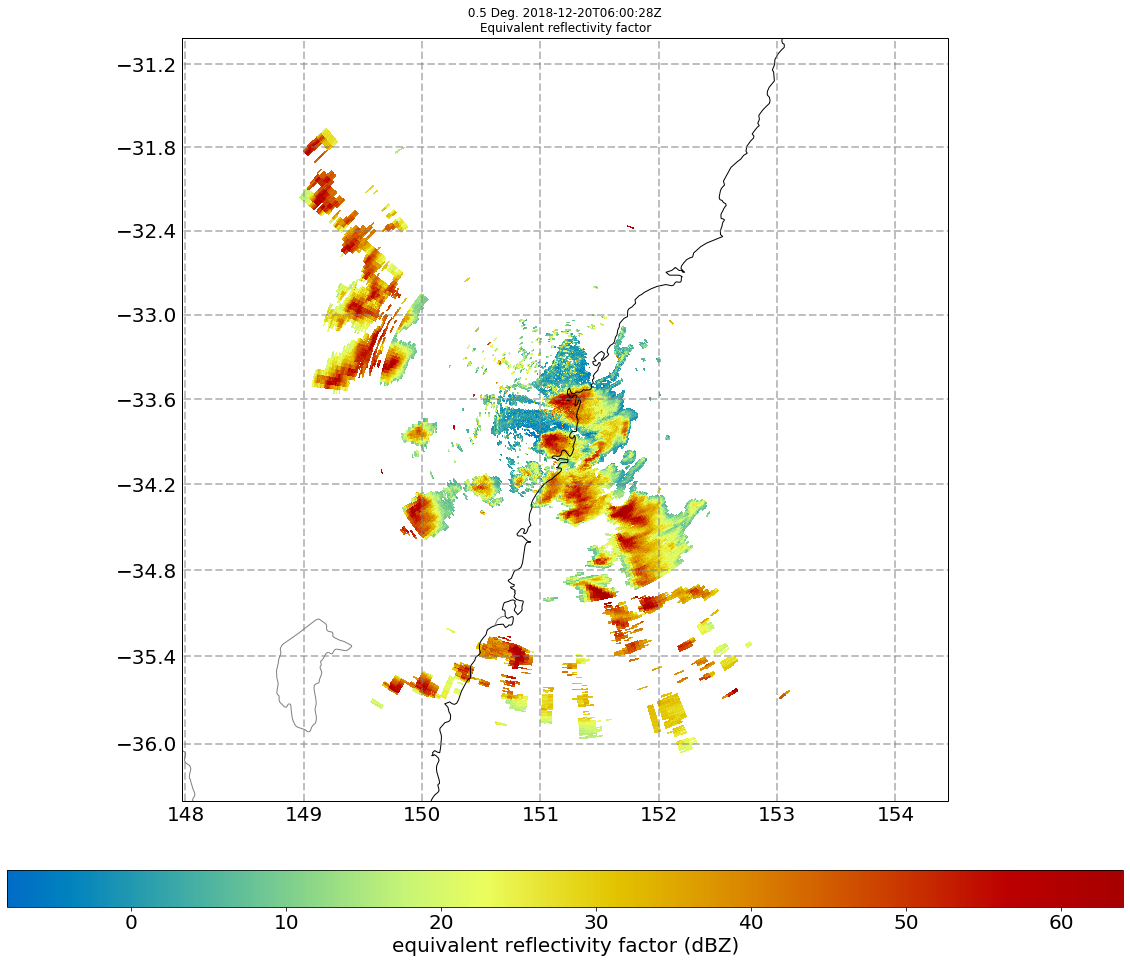

In [8]:
#pretty! but no context!
#lets use the Cartopy package to plot on a map

#I get a bit geeky on this... 

# lets get the extent of the data

lats = radar.gate_latitude
lons = radar.gate_longitude

min_lon = lons['data'].min()
min_lat = lats['data'].min()
max_lat = lats['data'].max()
max_lon = lons['data'].max()

print('min_lat:', min_lat, ' min_lon:', min_lon, 
      ' max_lat:', max_lat, ' max_lon:', max_lon)


#set up the plot
myf = plt.figure(figsize=[20,18])
display = pyart.graph.RadarMapDisplay(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

# Set up the GIS projection
projection = ccrs.Mercator(
                central_longitude=lon_0,
                min_latitude=min_lat, max_latitude=max_lat)

#plot a PPI. We specifically ask Py-ART not to add the colorbar... 
#We will customize this to make it nice.

display.plot_ppi_map(
    'reflectivity', 0,
    projection=projection, colorbar_flag=False,
    min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
    vmin=-8, vmax=64,
    resolution='10m')


#here is our pretty colorbar code
lb = display._get_colorbar_label('reflectivity')
cb = plt.colorbar(display.plots[0], aspect=30, pad=0.07, 
                  orientation='horizontal')

cb.ax.tick_params(labelsize=20)

cb.set_label(lb, fontsize=20)

#Now we add lat lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5,
                          linestyle='--')

gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

gl.xlabels_top = False
gl.ylabels_right = False

In [9]:
print(radar.fields['velocity']['data'].max())
print(radar.fields['velocity']['data'].min())

nan
nan


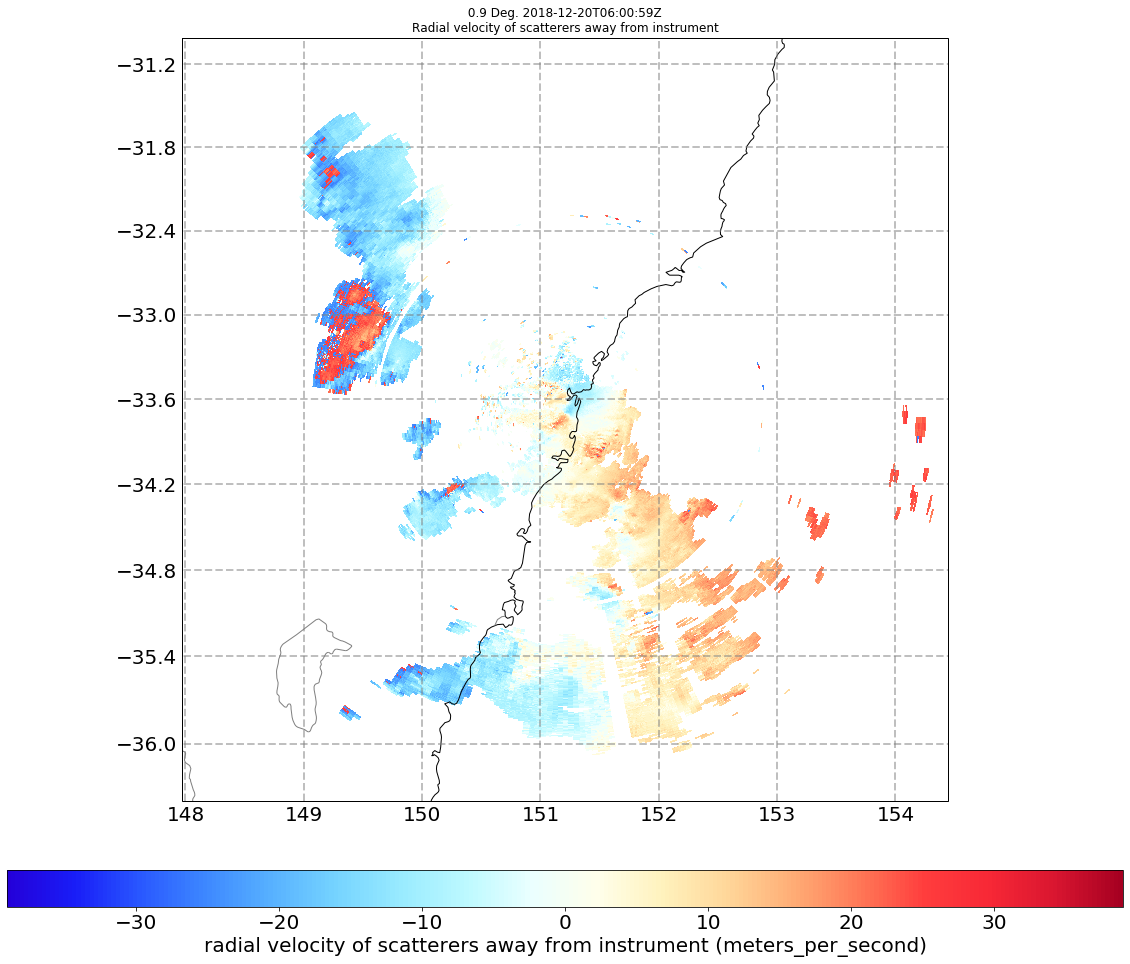

In [10]:
nyq = 39
#set up the plot
myf = plt.figure(figsize=[20,18])
display = pyart.graph.RadarMapDisplay(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

#plot a PPI. We specifically ask Py-ART not to add the colorbar... 
#We will customize this to make it nice.

display.plot_ppi_map(
    'velocity', 1,
    projection=projection, colorbar_flag=False,
    min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
    vmin=-nyq, vmax=nyq,
    resolution='10m')


#here is our pretty colorbar code
lb = display._get_colorbar_label('velocity')
cb = plt.colorbar(display.plots[0], aspect=30, pad=0.07, 
                  orientation='horizontal')

cb.ax.tick_params(labelsize=20)

cb.set_label(lb, fontsize=20)

#Now we add lat lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5,
                          linestyle='--')

gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

gl.xlabels_top = False
gl.ylabels_right = False

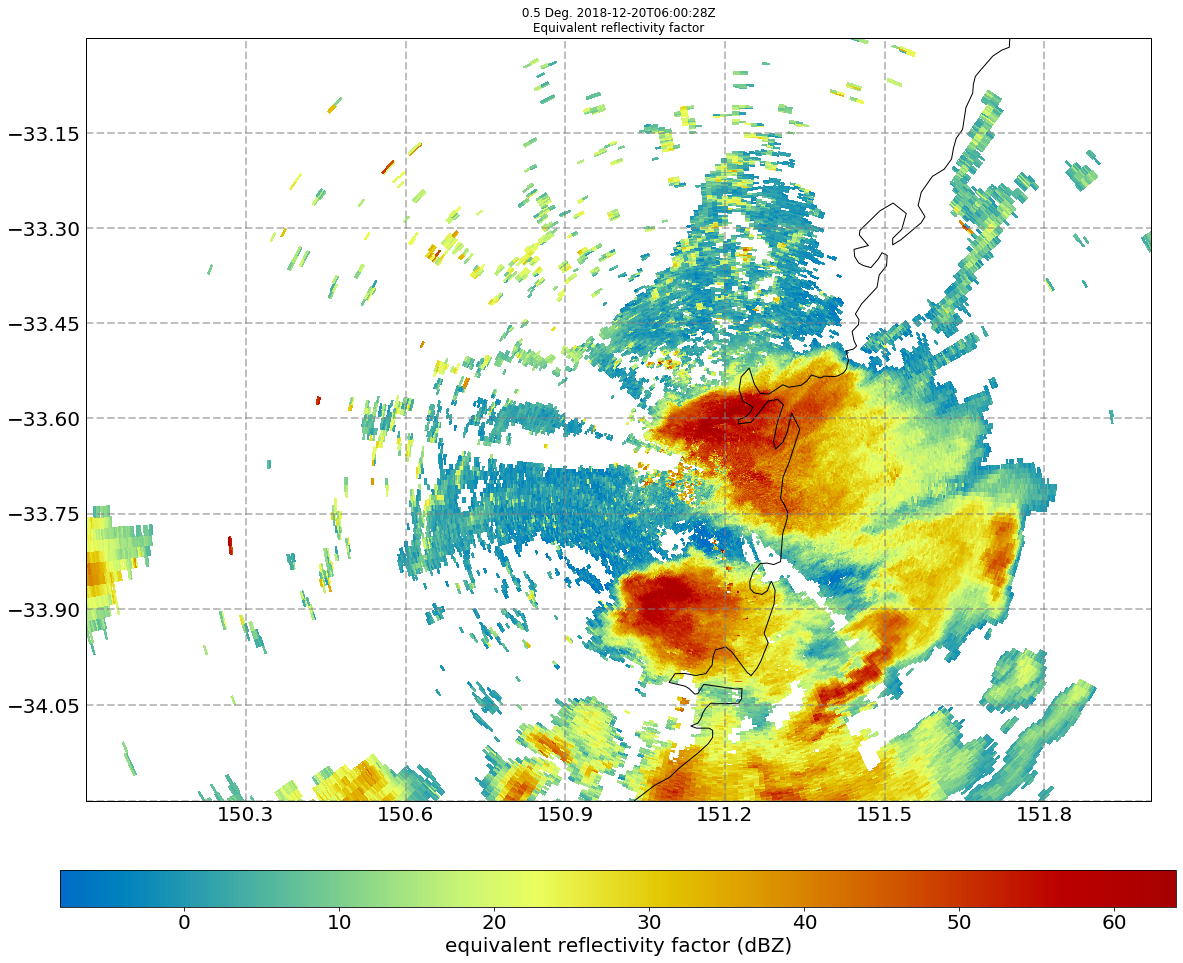

In [11]:
#pretty! but no context!
#lets use the Cartopy package to plot on a map

#I get a bit geeky on this... 

# lets get the extent of the data


#set up the plot
myf = plt.figure(figsize=[20,18])
display = pyart.graph.RadarMapDisplay(radar)

#plot a PPI. We specifically ask Py-ART not to add the colorbar... 
#We will customize this to make it nice.

display.plot_ppi_map(
    'reflectivity', 0,
    projection=projection, colorbar_flag=False,
    min_lon=150, max_lon=152, min_lat=-34.2, max_lat=-33,
    vmin=-8, vmax=64,
    resolution='10m')


#here is our pretty colorbar code
lb = display._get_colorbar_label('reflectivity')
cb = plt.colorbar(display.plots[0], aspect=30, pad=0.07, 
                  orientation='horizontal')

cb.ax.tick_params(labelsize=20)

cb.set_label(lb, fontsize=20)

#Now we add lat lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5,
                          linestyle='--')

gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

gl.xlabels_top = False
gl.ylabels_right = False

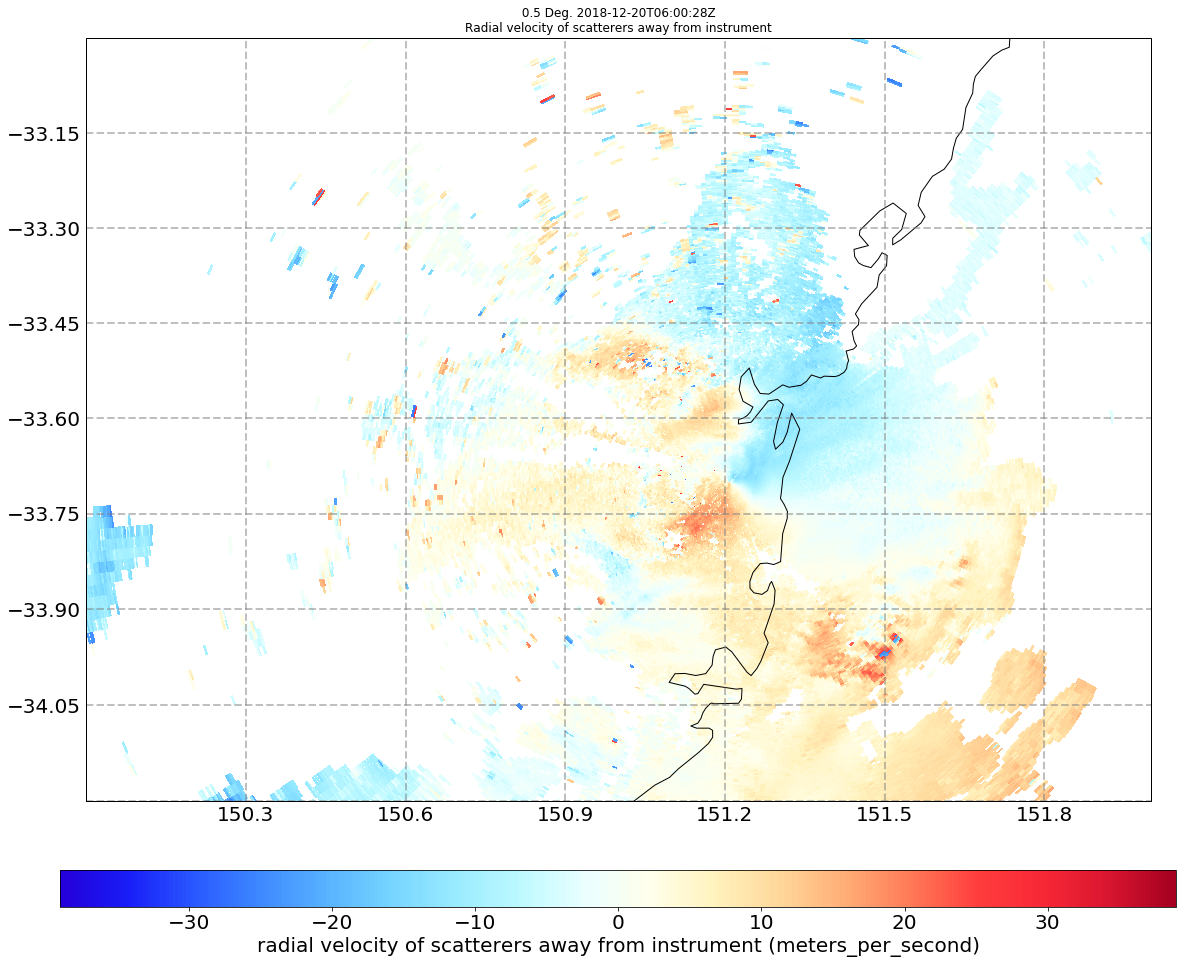

In [12]:
#pretty! but no context!
#lets use the Cartopy package to plot on a map

#I get a bit geeky on this... 

# lets get the extent of the data


#set up the plot
myf = plt.figure(figsize=[20,18])
display = pyart.graph.RadarMapDisplay(radar)

#plot a PPI. We specifically ask Py-ART not to add the colorbar... 
#We will customize this to make it nice.

display.plot_ppi_map(
    'velocity', 0,
    projection=projection, colorbar_flag=False,
    min_lon=150, max_lon=152, min_lat=-34.2, max_lat=-33,
    vmin=-nyq, vmax=nyq,
    resolution='10m')


#here is our pretty colorbar code
lb = display._get_colorbar_label('velocity')
cb = plt.colorbar(display.plots[0], aspect=30, pad=0.07, 
                  orientation='horizontal')

cb.ax.tick_params(labelsize=20)

cb.set_label(lb, fontsize=20)

#Now we add lat lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5,
                          linestyle='--')

gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

gl.xlabels_top = False
gl.ylabels_right = False

In [30]:
# Lets explore structure with a sythetic RHI
rhi_radar = pyart.util.xsect.cross_section_ppi(radar, [210])

(0, 100)

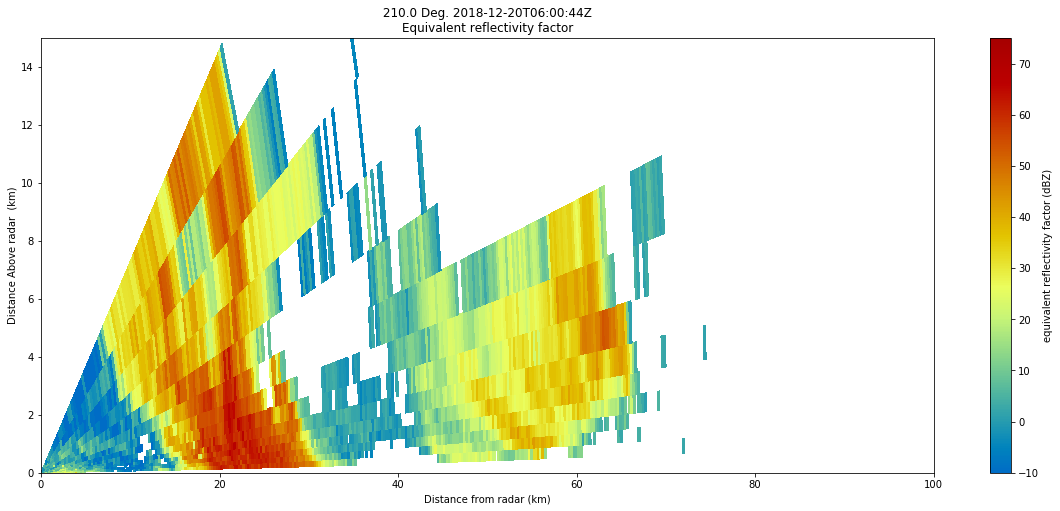

In [31]:
myf = plt.figure(figsize=[20,8])
display = pyart.graph.RadarDisplay(rhi_radar)
display.plot_rhi('reflectivity', 0, vmin=-10)
plt.ylim([0,15])
plt.xlim([0,100])


(0, 100)

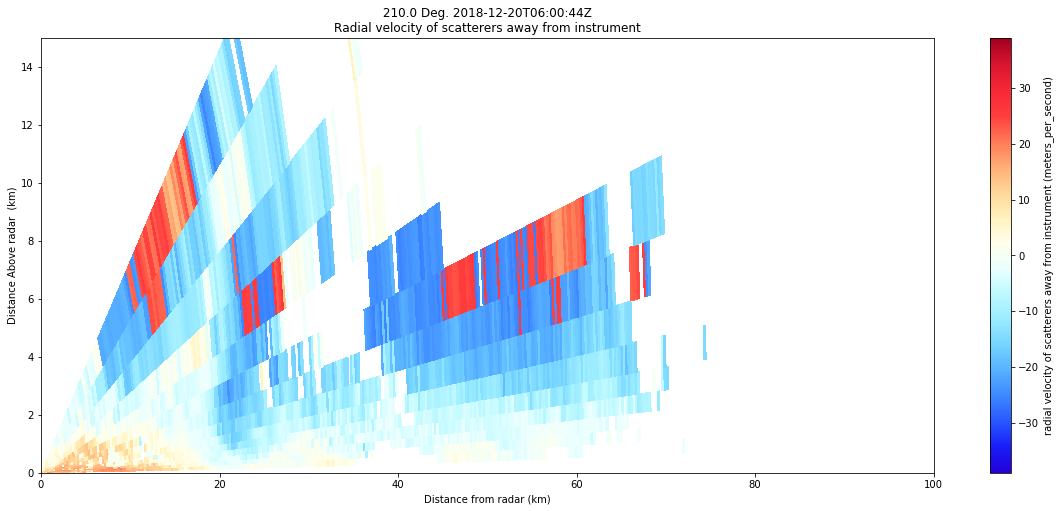

In [32]:
myf = plt.figure(figsize=[20,8])
display = pyart.graph.RadarDisplay(rhi_radar)
display.plot_rhi('velocity', 0, vmin=-nyq, vmax=nyq)
plt.ylim([0,15])
plt.xlim([0,100])


In [102]:
#we have doppler velocity alaising! 

In [104]:
#get profile from reanalysis
dset = xr.load_dataset(os.path.expanduser('~/data/era5_data.nc'))

In [105]:
cprof = dset.sel(longitude=28.5, latitude=-26.0, method='nearest')

In [107]:
#Geopotential height to height... ish...
height = cprof.z/(9.8)

In [113]:
profile = pyart.core.HorizontalWindProfile.from_u_and_v(
        height[0].values, cprof.u[0].values , cprof.v[0].values)

In [114]:
sim_vel = pyart.util.simulated_vel_from_profile(radar, profile)
radar.add_field('simulated_velocity', sim_vel, replace_existing=True)

In [116]:
corr_vel = pyart.correct.dealias_region_based(radar, vel_field='velocity', 
                                              ref_vel_field='simulated_velocity', 
                                              keep_original=False, 
                                              centered=True, nyquist_vel=39.0)

/Users/scollis/anaconda3/envs/saws/lib/python3.6/site-packages/pyart/correct/region_dealias.py:243: UserWarning: Warning: converting a masked element to nan.
  sref_means[reg-1] = np.ma.mean(sref[labels_corr == reg])


In [117]:
radar.add_field('corrected_velocity', corr_vel, replace_existing=True)

In [118]:
# Lets explore structure with a sythetic RHI
rhi_radar = pyart.util.xsect.cross_section_ppi(radar, [55])


(0, 15)

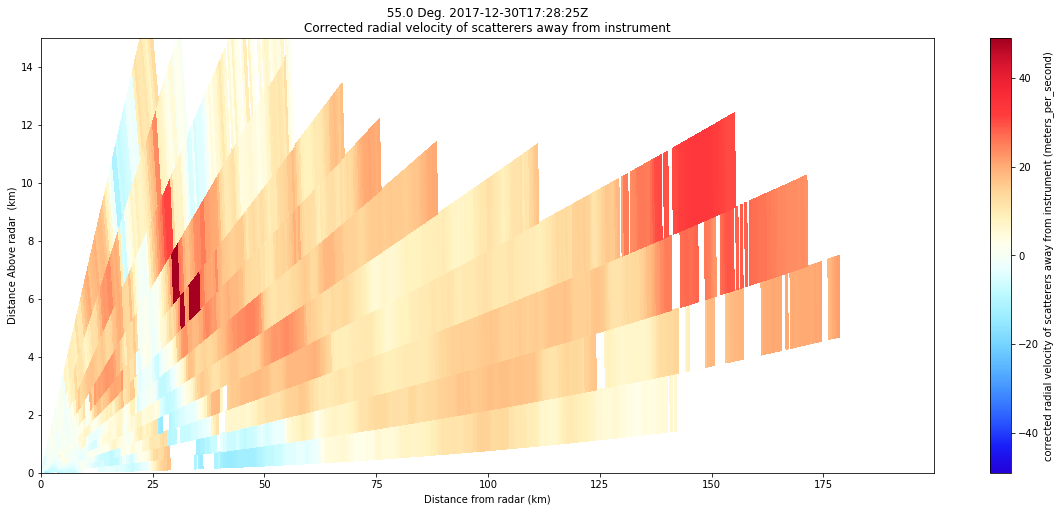

In [121]:
myf = plt.figure(figsize=[20,8])
display = pyart.graph.RadarDisplay(rhi_radar)
display.plot_rhi('corrected_velocity', 0, vmin=-nyq - 10, vmax=nyq + 10)
plt.ylim([0,15])


In [122]:
#Gridding!

In [126]:
grids = pyart.map.grid_from_radars(radar,(31,801,801),
                   ((0.,15000.),(-200000.,200000.),(-200000.,200000.)),
                   fields=radar.fields.keys(),
                   refl_field='reflectivity', weighting_function='BARNES2')  

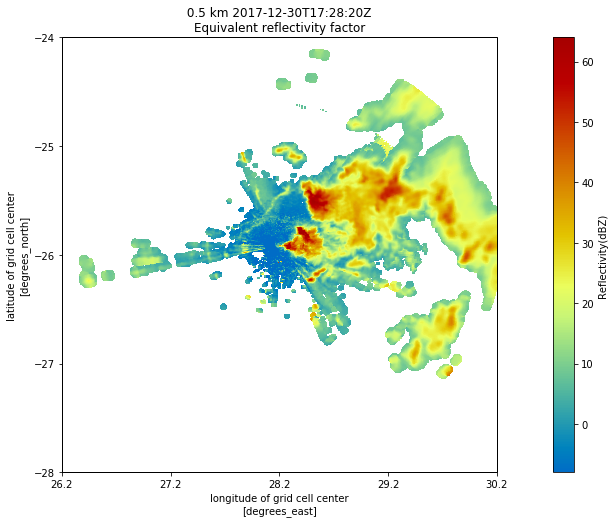

In [136]:
myf = plt.figure(figsize=[20,8])
gdisp = pyart.graph.GridMapDisplay(grids)
gdisp.plot_grid('reflectivity', level=1, vmin=-8, vmax=64)

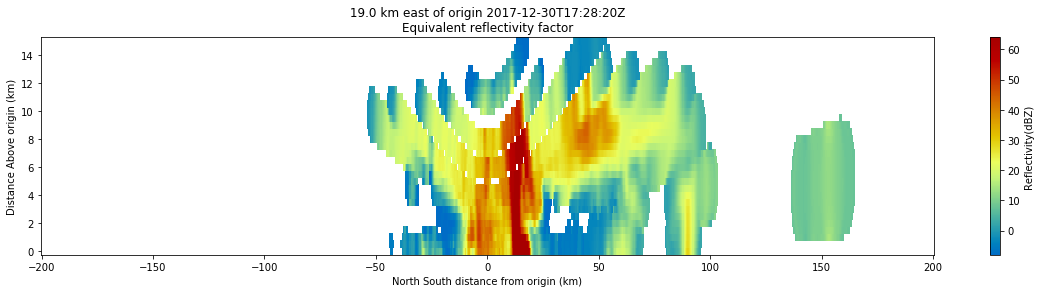

In [141]:
myf = plt.figure(figsize=[20,4])
gdisp = pyart.graph.GridMapDisplay(grids)
gdisp.plot_longitude_slice('reflectivity', lon=28.4, vmin=-8, vmax=64)

In [199]:
inner_grids = pyart.map.grid_from_radars(radar,(31,201,201),
                   ((0.,15000.),(-50000.,50000.),(-50000.,50000.)),
                   fields=radar.fields.keys(),
                   refl_field='reflectivity', weighting_function='BARNES2')  

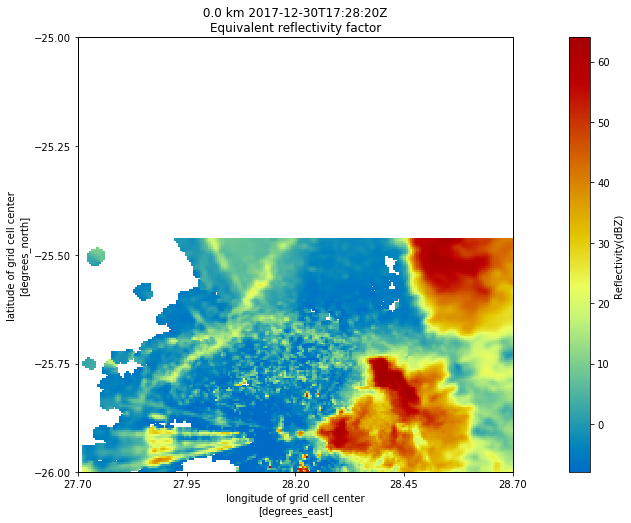

In [217]:
myf = plt.figure(figsize=[20,8])
gdisp = pyart.graph.GridMapDisplay(inner_grids)
gdisp.plot_grid('reflectivity', level=0, vmin=-8, vmax=64)
#plt.ylim([-26.5, -25.59])

In [200]:
u_init, v_init, w_init = pydda.initialization.make_wind_field_from_profile(inner_grids, profile)

In [201]:
new_grids = pydda.retrieval.get_dd_wind_field([inner_grids],
                                    u_init, v_init, w_init,
                                    Co=1.0, Cm=1500.0, frz=4000.0,
                                    mask_outside_opt=False, 
                                    vel_name='corrected_velocity')

Starting solver 
rmsVR = 13.01792067690486
Total points:532877.0
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|  69.3808| 506.6530|   0.0000|   0.0000|   0.0000|   0.0000|  85.6735
Norm of gradient: 0.13374825795386805
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|  40.8080| 388.5702|   0.0000|   0.0000|   0.0000|   0.0000|  91.3964
Norm of gradient: 0.33901645830257976
Iterations before filter: 20
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|  28.7466| 323.0823|   0.0000|   0.0000|   0.0000|   0.0000|  96.2733
Norm of gradient: 0.30993007936732436
Iterations before filter: 30
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|  18.8761| 291.1466|   0.0000|   0.0000|   0.0000|   0.0000|  98.8824
Norm of gradient: 0.3225454196501359
Iterations before filter: 40
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|  18.8761| 291.1466|   0.0000|   0.000

/Users/scollis/anaconda3/envs/saws/lib/python3.6/site-packages/pydda/vis/streamline_plot.py:394: RuntimeWarning: invalid value encountered in less
  w_filled = np.ma.masked_where(w[level, :, :] < np.min(w_vel_contours),
/Users/scollis/anaconda3/envs/saws/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1400: UserWarning: linewidths is ignored by contourf
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


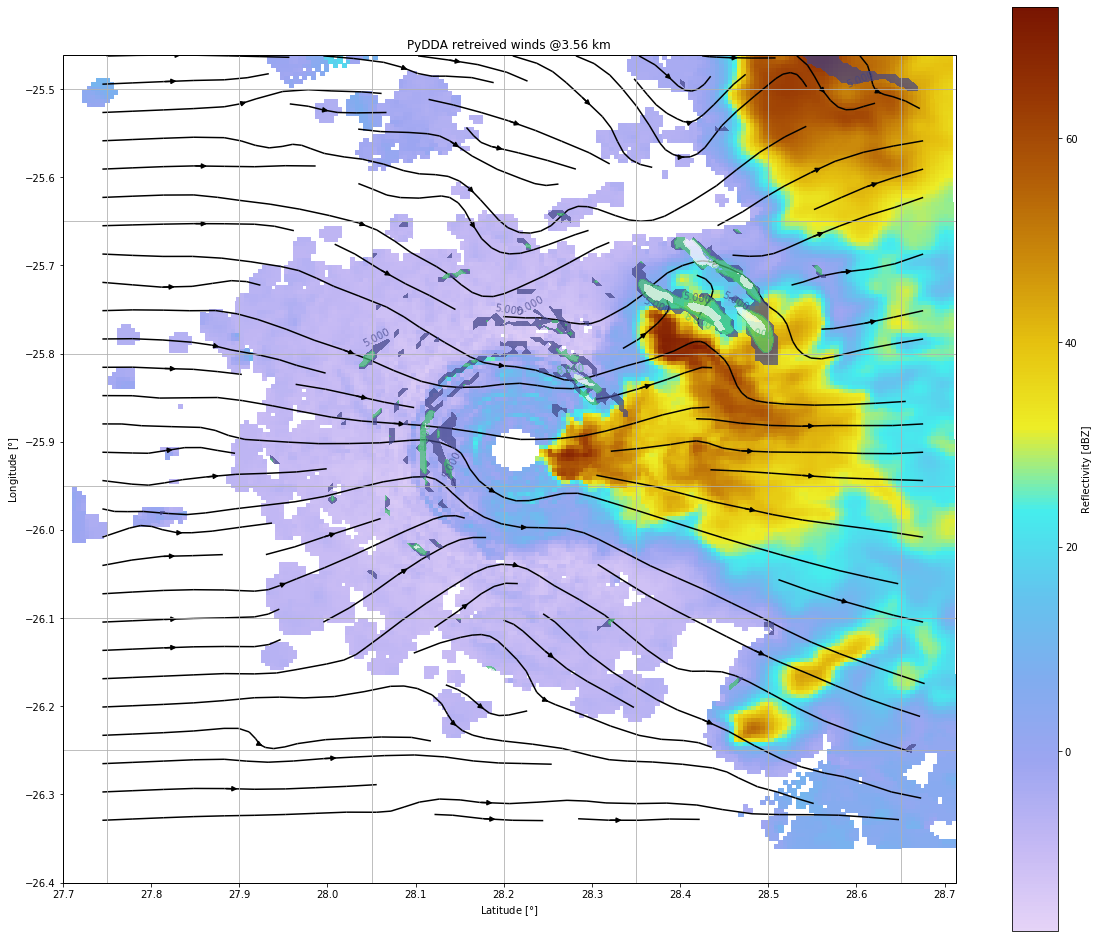

In [204]:
fig = plt.figure(figsize=(20, 17))
ax = plt.axes(projection=ccrs.PlateCarree())
pydda.vis.plot_horiz_xsection_streamlines_map(
    new_grids, ax=ax, bg_grid_no=-1, level=4, w_vel_contours=[3, 5, 8])

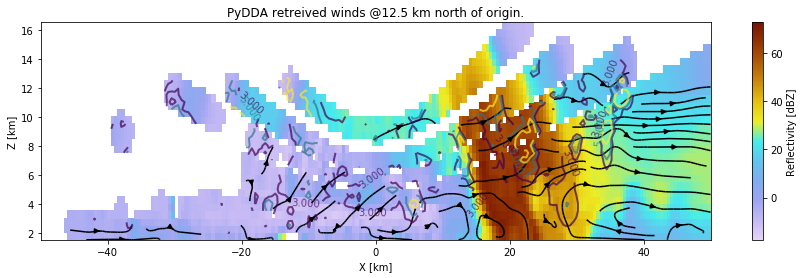

In [216]:
fig = plt.figure(figsize=(15, 4))
ax = plt.axes()
pydda.vis.plot_xz_xsection_streamlines(new_grids, ax=ax,
                                     bg_grid_no=-1, level=125,
                                     w_vel_contours=[3, 5, 8])


In [224]:
pyart.io.write_grid(os.path.expanduser('~/data/one_we_prepared_earlier.nc'), new_grids[0])